# MA221 Assignment 7: 2D Fast Multipole Method

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import fmm
%matplotlib inline
default_dpi = plt.rcParamsDefault['figure.dpi']
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "figure.dpi" : 2*default_dpi}
plt.rcParams.update(params)

## Do a quick test run of the code

In [4]:
particles = [fmm.Particle(*p, 1) for p in np.random.rand(100,2)]
particlesDS = deepcopy(particles)

def reset_particles(particles):
    for p in particles:
        p.phi = 0

### Visualize the adaptive quadtree

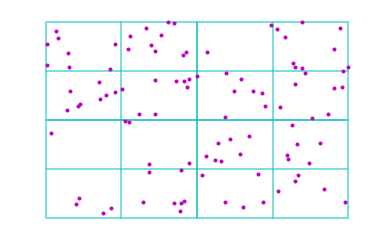

In [5]:
tree = fmm.build_tree(particles, tree_thresh=10)
fig, ax = plt.subplots(1)
pos = np.array([p.pos for p in particles])
pc = PatchCollection([Rectangle((p.x0,p.y0), p.w, p.h) for p in tree.root.traverse()],
                     facecolors='none', edgecolors='c', linewidth=2, alpha=.3)
ax.add_collection(pc)
ax.scatter(pos[:,0], pos[:,1], c='m',marker='.')

### Look at some preliminary results

Total percent error is 3.289305325481856e-14%


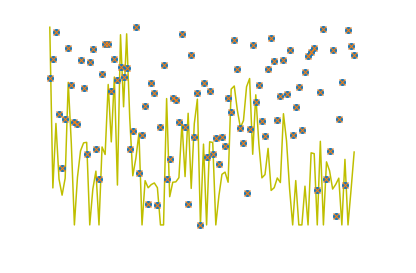

In [6]:
reset_particles(particles), reset_particles(particlesDS)
fmm.potential(particles, nterms=30, tree_thresh=10)
phi = np.array([p.phi for p in particles])
phiDS = fmm.potentialDS(particlesDS)
fig, ax = plt.subplots()
ax.set_ylabel('FMM percent error')
ax.set_xlabel('Particle')
ax2 = ax.twinx()
ax.plot(100*abs(phiDS - phi)/phiDS, 'y')
ax2.plot(phi, 'o')
ax2.plot(phiDS, 'x')
ax2.set_ylabel('Potential (arb)')
print('Total percent error is {}%'.format(100*np.linalg.norm(phiDS - phi)/np.linalg.norm(phiDS)))

## Now check the scaling

In [33]:
from time import time
#from multiprocessing import Pool
from functools import wraps

def time_function(func, *args, **kwargs):
    @wraps(func)
    def tfunc(*args, **kwargs):
        start = time()
        res = func(*args, **kwargs)
        runtime = 1000*(time() - start)
        return runtime
    return tfunc
    
fmmtimed = time_function(fmm.potential)
fmmNOtree = time_function(fmm.potentialFMM)
directtimed = time_function(fmm.potentialDS)
treetimed = time_function(fmm.build_tree)

In [14]:
particles = [fmm.Particle(*p, 1) for p in np.random.rand(100,2)]
%time fmm.potential(particles, nterms=5, tree_thresh=5)
%time _ = fmm.potentialDS(particles)

CPU times: user 65.9 ms, sys: 501 µs, total: 66.4 ms
Wall time: 65.2 ms
CPU times: user 33.2 ms, sys: 0 ns, total: 33.2 ms
Wall time: 32.8 ms


In [48]:
t_fmm, t_direct = [], []
size = np.array([100, 200, 300, 400, 500, 1000, 1500])

pinit = lambda n: [fmm.Particle(*p, 1) for p in np.random.rand(n,2)]
tinit = lambda n: fmm.build_tree(pinit(n), tree_thresh=n//10)

In [49]:
t_fmm_notree = list(map(fmmNOtree, map(tinit, size)))
t_fmm = list(map(fmmtimed, map(pinit, size)))
t_direct = list(map(directtimed, map(pinit, size)))

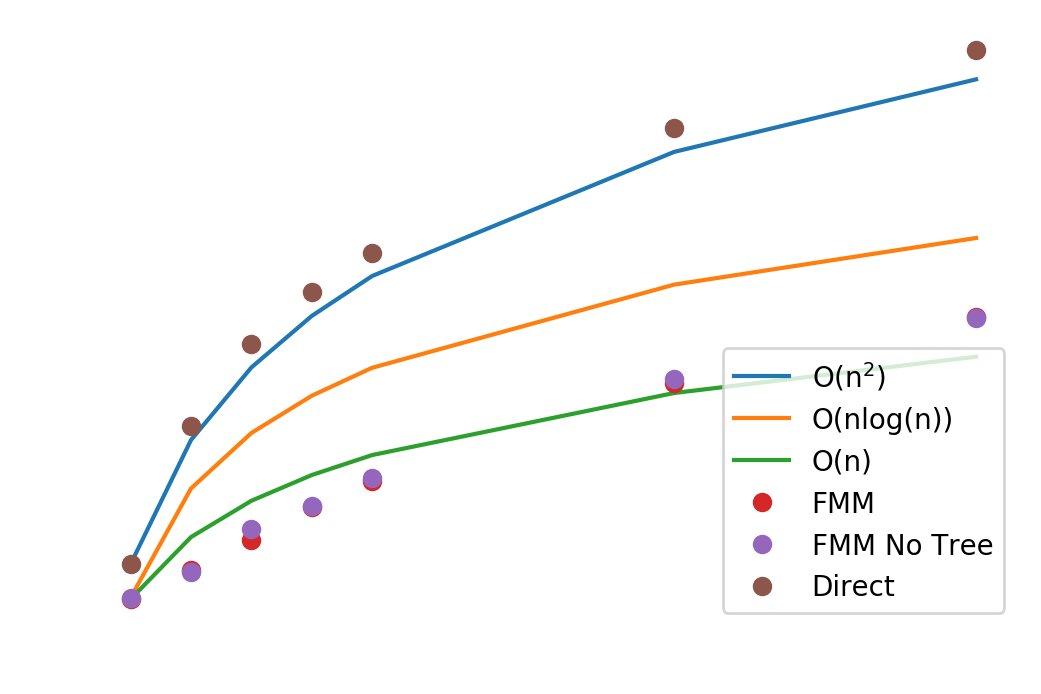

In [50]:
sizen = size/size[0]
plt.semilogy(size, t_direct[0]*(sizen)**2)
plt.semilogy(size, t_fmm_notree[0]*sizen*np.log(np.e*sizen))
plt.semilogy(size, t_fmm[0]*sizen)
plt.semilogy(size, t_fmm, 'o')
plt.semilogy(size, t_fmm_notree, 'o')
plt.semilogy(size, t_direct, 'o')
plt.legend([r'O(n$^2$)', 'O(nlog(n))', 'O(n)', 'FMM', 'FMM No Tree', 'Direct'])

In [31]:
particles = [fmm.Particle(*p, 1) for p in np.random.rand(10000,2)]
%time fmm.build_tree(particles, tree_thresh=2)

CPU times: user 366 ms, sys: 4 ms, total: 370 ms
Wall time: 377 ms


In [ ]:
def time_function(func, *args, **kwargs):
    @wraps(func)
    def tfunc(*args, **kwargs):
        start = time()
        res = func(*args, **kwargs)
        runtime = 1000*(time() - start)
        return runtime
    return tfunc, res

terms = np.array((1, 5, 10, 15, 20, 25, 30))
pinitf = lambda n: [fmm.Particle(*p, 1) for p in np.random.rand(n,2)]